In [2]:
import pandas as pd
import vcfpy
from SigProfilerAssignment import Analyzer as Analyze
import musical
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import os
import shutil
import ast
from tqdm import tqdm 
import re
import sys
from scipy import stats
from contextlib import redirect_stdout
from tabulate import tabulate
import csv
from scipy.stats import linregress
import numpy as np, pandas as pd, matplotlib.pyplot as plt
from scipy import odr
import numpy as np, pandas as pd, matplotlib.pyplot as plt
import matplotlib as mpl
import logging
from pathlib import Path

logging.getLogger().setLevel(logging.WARNING)
pd.options.mode.chained_assignment = None
mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['font.size'] = 13  
pd.set_option("display.max_columns", None)
%matplotlib inline

project_root = Path().resolve().parent.parent  # go up from notebooks/ to HRDTimer/
sys.path.append(str(project_root))

from hrdtimer import utils as HRDTimerUtils

# PCAWG

In [3]:
vcf_folder_path = "/Volumes/extSSD/park_lab/HRDTimer_Analysis/AA_NEW_TEST_RUN_PCAWG_Apr25_v2/Breast/all_mut"
PCAWG_breast_samples = HRDTimerUtils.prepare_samples_for_timing(vcf_folder_path)

Processing Early samples:


Processing Files: 100%|██████████| 207/207 [00:36<00:00,  5.68it/s]


Processing Late samples:


Processing Files: 100%|██████████| 184/184 [00:37<00:00,  4.97it/s]


Processing NA samples:


Processing Files: 100%|██████████| 208/208 [01:31<00:00,  2.28it/s]


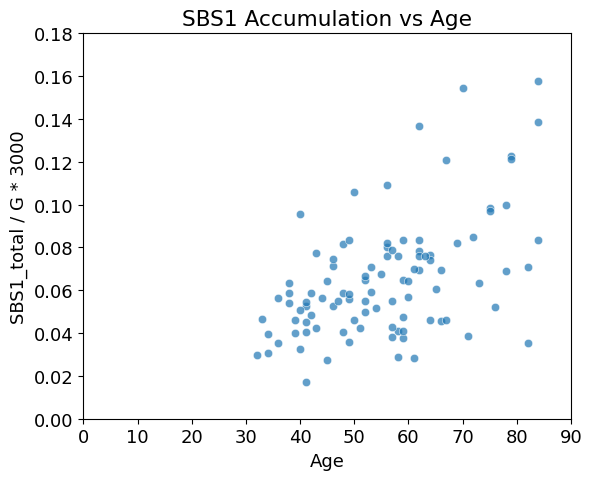

In [4]:
G_values = {sample_id: HRDTimerUtils.G(df) for sample_id, df in PCAWG_breast_samples.items()}
G_df = pd.DataFrame.from_dict(G_values, orient='index', columns=['G']).reset_index()
G_df.rename(columns={'index': 'aliquot_id'}, inplace=True)

# Merge with PCAWG_Metadata
PCAWG_Metadata = pd.read_csv("/Volumes/extSSD/park_lab/HRDTimer_Analysis/breast_ovarian_summary_with_age_hrd_grade.csv")
PCAWG_Metadata = PCAWG_Metadata[['aliquot_id', 'age', 'WGD','isHRD', 'organ.x']]
PCAWG_Metadata.rename(columns={'organ.x': 'organ'}, inplace=True)
PCAWG_Metadata = PCAWG_Metadata[(PCAWG_Metadata['WGD']==True) & (PCAWG_Metadata['organ']=='Breast')]
PCAWG_Metadata = PCAWG_Metadata.merge(G_df, on='aliquot_id', how='left')

base = "/Volumes/extSSD/park_lab/HRDTimer_Analysis/AA_NEW_TEST_RUN_PCAWG_Apr25_v2/Breast/all_mut/SignatureFitting"
folders = {'Early': 'early', 'Late': 'late', 'NA': 'na'}

for p, s in folders.items():
    f = os.path.join(base, p, "exposures", "exposures_MuSiCal_lik.csv")
    if not os.path.exists(f): continue
    df = pd.read_csv(f, index_col=0)
    df.rename(columns={c: c.replace(f"_{s}", '') for c in df.columns if c.endswith(f"_{s}")}, inplace=True)
    sub = df.loc[['SBS1']].T
    sub.columns = [f'SBS1_{p}']
    sub.index.name = 'aliquot_id'
    PCAWG_Metadata = PCAWG_Metadata.merge(sub, on='aliquot_id', how='left')

PCAWG_Metadata['SBS1_total'] = PCAWG_Metadata[['SBS1_Early', 'SBS1_Late', 'SBS1_NA']].sum(axis=1)
PCAWG_Metadata['Cohort'] = "PCAWG"
PCAWG_Metadata['scaled_SBS1'] = PCAWG_Metadata['SBS1_total'] / (PCAWG_Metadata['G'] * 3000)

plt.figure(figsize=(6, 5))
sns.scatterplot(data=PCAWG_Metadata, x='age', y='scaled_SBS1', alpha=0.7)
plt.ylim(0,0.18)
plt.xlim(0,90)
plt.xlabel("Age")
plt.ylabel("SBS1_total / G * 3000")
plt.title("SBS1 Accumulation vs Age")
plt.tight_layout()
plt.show()

# SCANB

In [5]:
vcf_folder_path = "/Volumes/extSSD/park_lab/HRDTimer_Analysis/AA_NEW_TEST_RUN_SCANB_unfiltered_Apr25/Breast/all_mut"
SCANB_breast_samples = HRDTimerUtils.prepare_samples_for_timing(vcf_folder_path)

Processing Early samples:


Processing Files: 100%|██████████| 49/49 [00:15<00:00,  3.06it/s]


Processing Late samples:


Processing Files: 100%|██████████| 49/49 [00:14<00:00,  3.33it/s]


Processing NA samples:


Processing Files: 100%|██████████| 49/49 [00:16<00:00,  2.91it/s]


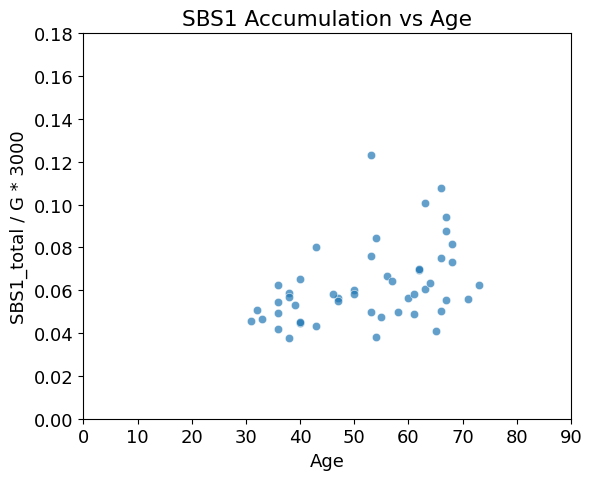

In [6]:
G_values = {sample_id: HRDTimerUtils.G(df) for sample_id, df in SCANB_breast_samples.items()}
G_df = pd.DataFrame.from_dict(G_values, orient='index', columns=['G']).reset_index()
G_df.rename(columns={'index': 'aliquot_id'}, inplace=True)

SCANB_Metadata = pd.read_csv("/Volumes/extSSD/park_lab/HRDTimer_Analysis/SCANB_metadata.csv")
SCANB_Metadata = SCANB_Metadata[['aliquot_id', 'Age', 'WGD', 'isHRD', 'organ']]
SCANB_Metadata.rename(columns={'Age': 'age'}, inplace=True)
SCANB_Metadata = SCANB_Metadata.merge(G_df, on='aliquot_id', how='left')

base = "/Volumes/extSSD/park_lab/HRDTimer_Analysis/AA_NEW_TEST_RUN_SCANB_unfiltered_Apr25/Breast/all_mut/SignatureFitting"
folders = {'Early': 'early', 'Late': 'late', 'NA': 'na'}

for p, s in folders.items():
    f = os.path.join(base, p, "exposures", "exposures_MuSiCal_lik.csv")
    if not os.path.exists(f): continue
    df = pd.read_csv(f, index_col=0)
    df.rename(columns={c: c.replace(f"_{s}", '') for c in df.columns if c.endswith(f"_{s}")}, inplace=True)
    sub = df.loc[['SBS1']].T
    sub.columns = [f'SBS1_{p}']
    sub.index.name = 'aliquot_id'
    SCANB_Metadata = SCANB_Metadata.merge(sub, on='aliquot_id', how='left')

SCANB_Metadata['SBS1_total'] = SCANB_Metadata[['SBS1_Early', 'SBS1_Late', 'SBS1_NA']].sum(axis=1)
SCANB_Metadata['Cohort'] = "SCANB"
SCANB_Metadata['scaled_SBS1'] = SCANB_Metadata['SBS1_total'] / (SCANB_Metadata['G'] * 3000)

plt.figure(figsize=(6, 5))
sns.scatterplot(data=SCANB_Metadata, x='age', y='scaled_SBS1', alpha=0.7)
plt.ylim(0,0.18)
plt.xlim(0,90)
plt.xlabel("Age")
plt.ylabel("SBS1_total / G * 3000")
plt.title("SBS1 Accumulation vs Age")
plt.tight_layout()
plt.show()

# INFORM

In [7]:
vcf_folder_path = "/Volumes/extSSD/park_lab/HRDTimer_Analysis/AA_NEW_TEST_RUN_INFORM_germline_filtered_v2/Breast/all_mut"
INFORM_breast_samples = HRDTimerUtils.prepare_samples_for_timing(vcf_folder_path)

Processing Early samples:


Processing Files: 100%|██████████| 19/19 [00:02<00:00,  6.65it/s]


Processing Late samples:


Processing Files: 100%|██████████| 19/19 [00:03<00:00,  4.91it/s]


Processing NA samples:


Processing Files: 100%|██████████| 19/19 [00:10<00:00,  1.88it/s]


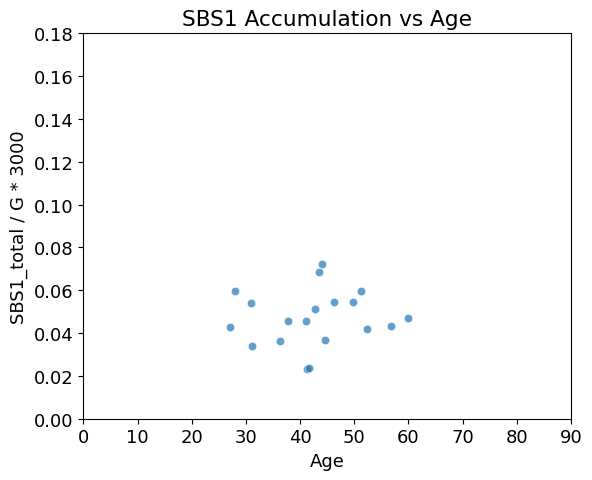

In [8]:
G_values = {sample_id: HRDTimerUtils.G(df) for sample_id, df in INFORM_breast_samples.items()}
G_df = pd.DataFrame.from_dict(G_values, orient='index', columns=['G']).reset_index()
G_df.rename(columns={'index': 'aliquot_id'}, inplace=True)

INFORM_Metadata_v1 = pd.read_csv('/Volumes/extSSD/park_lab/HRDTimer_Analysis/INFORM_metadata.csv')

INFORM_Metadata_v2 = pd.read_csv("/Volumes/extSSD/park_lab/HRDTimer_Analysis/clinical_data_deidentified_backup_Felipe_2021-02-08_annotated_2023_April30.txt", delimiter='\t')
INFORM_Metadata_v2['individual_display_title'] = 'Patient' +  INFORM_Metadata_v2['participant'].astype(str)
INFORM_Metadata_v2 = INFORM_Metadata_v2[['individual_display_title', 'age']]

INFORM_Metadata = INFORM_Metadata_v1.merge(INFORM_Metadata_v2, on='individual_display_title', how='inner')
INFORM_Metadata = INFORM_Metadata[['aliquot_id', 'age', 'WGD','isHRD', 'organ']]
INFORM_Metadata = INFORM_Metadata.merge(G_df, on='aliquot_id', how='left')

base = "/Volumes/extSSD/park_lab/HRDTimer_Analysis/AA_NEW_TEST_RUN_INFORM_germline_filtered_v2/Breast/all_mut/SignatureFitting"
folders = {'Early': 'early', 'Late': 'late', 'NA': 'na'}

for p, s in folders.items():
    f = os.path.join(base, p, "exposures", "exposures_MuSiCal_lik.csv")
    if not os.path.exists(f): continue
    df = pd.read_csv(f, index_col=0)
    df.rename(columns={c: c.replace(f"_{s}", '') for c in df.columns if c.endswith(f"_{s}")}, inplace=True)
    sub = df.loc[['SBS1']].T
    sub.columns = [f'SBS1_{p}']
    sub.index.name = 'aliquot_id'
    INFORM_Metadata = INFORM_Metadata.merge(sub, on='aliquot_id', how='left')

INFORM_Metadata['SBS1_total'] = INFORM_Metadata[['SBS1_Early', 'SBS1_Late', 'SBS1_NA']].sum(axis=1)
INFORM_Metadata['Cohort'] = "INFORM"
INFORM_Metadata['scaled_SBS1'] = INFORM_Metadata['SBS1_total'] / (INFORM_Metadata['G'] * 3000)

plt.figure(figsize=(6, 5))
sns.scatterplot(data=INFORM_Metadata, x='age', y='scaled_SBS1', alpha=0.7)
plt.ylim(0,0.18)
plt.xlim(0,90)
plt.xlabel("Age")
plt.ylabel("SBS1_total / G * 3000")
plt.title("SBS1 Accumulation vs Age")
plt.tight_layout()
plt.show()

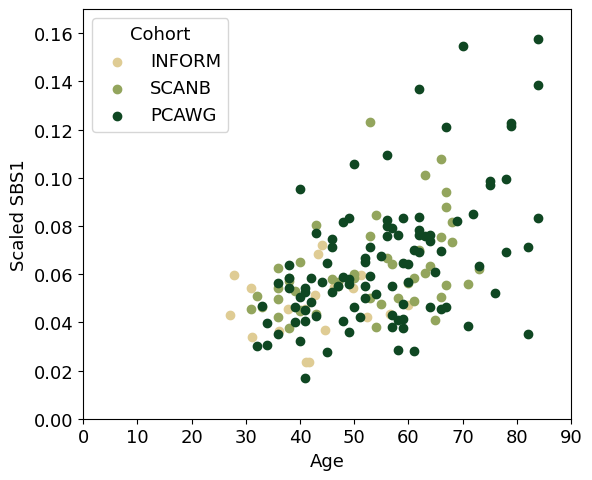

In [9]:
SBS1_acceleration_df = pd.concat([PCAWG_Metadata, SCANB_Metadata, INFORM_Metadata])
SBS1_acceleration_df.to_csv("/Volumes/extSSD/park_lab/HRDTimer_Analysis/AAA_Apr25_plots/data/PCAWG_SCANB_INFORM_SBS1_Age_plot.csv")

colors = {'INFORM': '#DFCC94', 'SCANB': '#93A55D', 'PCAWG': '#0F4722'}

fig, ax = plt.subplots(figsize=(6, 5))
for cohort, color in colors.items():
    df = SBS1_acceleration_df[SBS1_acceleration_df['Cohort'] == cohort]
    ax.scatter(df['age'], df['scaled_SBS1'], label=cohort, color=color)

ax.set_xlabel('Age')
ax.set_ylabel('Scaled SBS1')
ax.legend(title='Cohort')
plt.xlim(0, 90)
plt.ylim(0, 0.17)
plt.tight_layout()
plt.show()


# Include Normal Tissue Data

In [ ]:
# Load mutation matrix (Eg from SigProfiler output)
X = pd.read_csv('../../output/SBS/Input_vcffiles.SBS96.all', delimiter='\t', index_col=0)
# Load an example MuSiCal catalog to get the index order
catalog = musical.load_catalog('COSMIC_v3p2_SBS_WGS')
W = catalog.W
# Re-index count matrix
X = X.reindex(W.index)

,HV011-sc-1,HV011-sc-2,HV021-sc-1,HV119-sc-1,HV190-sc-1,HV203-sc-3,HV203-sc-4,HV203-sc-7,HV319-sc-2,HV319-sc-4,HV319-sc-5,HV319-sc-6,KU1018-sc-1,KU1018-sc-2,KU1020-sc-1,KU1020-sc-2,KU1025-sc-1,KU1025-sc-2,KU1025-sc-3,KU1025-sc-4,KU1025-sc-5,KU1026-sc-1,KU1026-sc-2,KU1026-sc-3,KU1026-sc-4,KU1026-sc-5,KU1035-sc-2,KU1037-sc-1,KU1038-sc-1,KU1038-sc-2,KU1038-sc-3,KU1038-sc-4,KU1038-sc-5,KU1038-sc-6,KU1040-sc-1,KU1040-sc-2,KU1040-sc-3,KU1040-sc-4,KU1040-sc-5,KU1045-sc-1,KU1045-sc-2,KU1045-sc-3,KU1045-sc-4,KU1045-sc-5,KU1047-sc-1,KU1047-sc-2,KU1047-sc-3,KU1056-sc-1,KU1056-sc-2,KU1056-sc-3,KU1056-sc-4,KU1056-sc-5,KU1057-sc-1,KU1057-sc-2,KU1057-sc-4,KU1058-sc-1,KU1058-sc-2,KU1058-sc-3,KU1058-sc-4,KU1160-sc-1,KU1171-sc-1,KU1171-sc-2,KU1171-sc-3,KU1171-sc-4,remove_quotes
Type,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
A[C>A]A,20,15,13,8,15,14,5,11,8,20,11,17,21,25,12,14,17,23,24,24,17,18,11,24,24,20,22,22,10,14,15,12,17,23,24,15,20,24,19,23,26,15,23,18,9,17,14,19,29,16,12,24,14,15,11,11,21,16,18,16,11,11,12,9,0
A[C>A]C,12,9,4,2,4,4,4,4,6,13,6,8,13,15,2,6,4,9,7,16,12,8,11,12,9,7,18,14,4,8,9,7,15,13,5,10,6,9,14,8,11,10,15,9,6,3,7,8,12,12,8,11,11,8,12,10,11,4,5,7,12,8,10,12,0
A[C>A]G,1,1,3,1,1,5,1,1,1,0,2,1,2,1,2,0,1,3,0,3,4,3,3,1,2,3,3,8,4,4,4,5,5,5,0,2,2,0,1,1,5,3,1,3,2,2,3,3,5,1,3,3,4,0,2,1,1,1,1,2,3,1,2,3,0
A[C>A]T,12,9,4,6,6,7,4,7,9,7,8,10,15,11,4,6,9,10,9,13,10,13,10,9,5,13,16,8,6,14,13,15,10,14,13,17,13,16,11,11,8,10,7,7,6,3,7,17,18,10,7,14,14,7,14,5,11,7,11,10,8,4,11,8,0
C[C>A]A,11,10,8,5,11,13,3,7,8,15,10,10,15,14,12,13,14,13,14,29,14,11,11,15,24,9,18,16,13,17,16,18,20,14,22,11,14,21,18,24,24,19,14,9,5,10,13,20,16,19,15,17,21,17,13,17,14,18,20,13,13,7,13,10,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
G[T>G]T,3,2,1,2,3,1,1,0,3,4,1,0,2,4,1,3,4,4,6,4,0,0,1,7,3,2,4,7,5,3,3,3,5,4,3,6,5,4,1,3,5,2,6,2,2,1,0,4,3,4,1,3,0,1,1,5,2,3,2,4,6,2,4,1,0
T[T>G]A,2,0,0,1,2,2,1,1,5,0,1,1,10,6,4,4,7,4,3,6,3,10,9,6,5,8,4,3,6,2,7,5,5,4,10,7,6,3,4,6,6,3,4,7,3,0,2,6,8,7,2,8,4,5,2,4,1,4,5,9,4,4,1,2,0
T[T>G]C,1,2,4,3,3,3,0,3,5,2,4,0,7,13,3,3,7,3,6,3,6,5,2,6,4,4,3,2,4,6,9,8,3,3,8,6,5,8,3,2,8,4,4,5,4,3,1,6,6,7,9,8,6,3,1,4,8,6,2,9,4,1,8,0,0


In [10]:
mutation_matrix = pd.read_csv('/Volumes/extSSD/park_lab/HRDTimer_Analysis/Japanese_data/vcfs/output/SBS/Input_vcffiles.SBS96.all', delimiter='\t', index_col=0)
catalog = musical.load_catalog('COSMIC_v3p2_SBS_WGS')
catalog.restrict_catalog(tumor_type='Breast.AdenoCA', is_MMRD=False, is_PPD=False)
W = catalog.W
W = W.reindex(mutation_matrix.index)
mutation_matrix = mutation_matrix.loc[:, (mutation_matrix != 0).any(axis=0)]
H, model = musical.refit.refit(mutation_matrix, W, method='likelihood_bidirectional', thresh=0.001)

In [11]:
norm_tissue_data = pd.read_csv("/Volumes/extSSD/park_lab/HRDTimer_Analysis/Japanese_Fig1.txt", delimiter='\t')

NormalTissueExposures = H.T
NormalTissueExposures['sample'] = NormalTissueExposures.index
NormalTissueExposures = NormalTissueExposures[['sample', 'SBS1']]
NormalTissueExposures = NormalTissueExposures.merge(norm_tissue_data, on='sample')
NormalTissueExposures['scaled_SBS1'] = NormalTissueExposures['SBS1'] / (2 * 3000)
NormalTissueExposures = NormalTissueExposures[NormalTissueExposures['group'] != 'BC (postmenopausal)']
#NormalTissueExposures.to_csv("/Volumes/extSSD/park_lab/HRDTimer_Analysis/AAA_Apr25_plots/data/NormalTissue_SBS1_Age_plot.csv")
NormalTissueExposures.head()

,sample,SBS1,case,group,age,driver,SNV number,indel number,scaled_SBS1
0,HV011-sc-1,141.033304,HV011,HV (premenopausal),36,None,715,51,0.023506
1,HV011-sc-2,80.326500,HV011,HV (premenopausal),36,None,597,43,0.013388
2,HV021-sc-1,83.547793,HV021,HV (premenopausal),30,None,490,30,0.013925
3,HV119-sc-1,49.529362,HV119,HV (premenopausal),34,None,393,22,0.008255
4,HV190-sc-1,73.163198,HV190,HV (premenopausal),37,None,675,43,0.012194


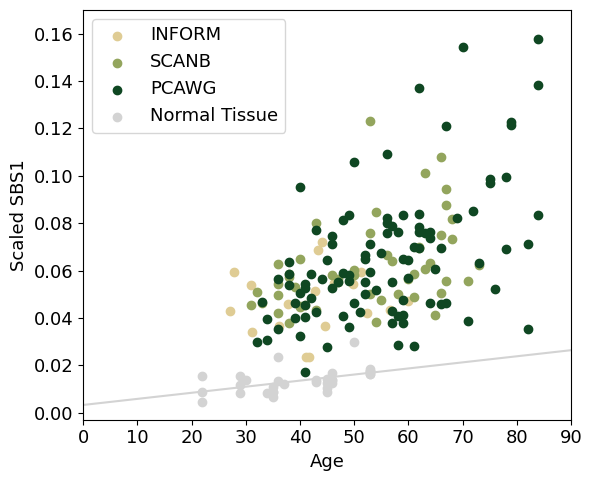

In [12]:
x = NormalTissueExposures['age']
y = NormalTissueExposures['scaled_SBS1']
slope, intercept, *_ = linregress(x, y)
x_fit = np.linspace(0, 90, 100)
y_fit = slope * x_fit + intercept

SBS1_acceleration_df = pd.concat([PCAWG_Metadata, SCANB_Metadata, INFORM_Metadata])
colors = {'INFORM': '#DFCC94', 'SCANB': '#93A55D', 'PCAWG': '#0F4722'}

fig, ax = plt.subplots(figsize=(6, 5))
for cohort, color in colors.items():
    df = SBS1_acceleration_df[SBS1_acceleration_df['Cohort'] == cohort]
    ax.scatter(df['age'], df['scaled_SBS1'], label=cohort, color=color)

ax.scatter(x, y, color='lightgrey', label='Normal Tissue')
ax.plot(x_fit, y_fit, '-', color='lightgrey')

ax.set(xlabel='Age', ylabel='Scaled SBS1')
ax.legend()
plt.xlim(0, 90)
plt.ylim(-0.003, 0.17)
plt.tight_layout()
plt.savefig("/Users/michail/HMS Dropbox/Michail Andreopoulos/HRDTimer/data/output/output_plots/SBS1_Acceleration_Bulk.pdf", format='pdf', bbox_inches='tight')
plt.show()


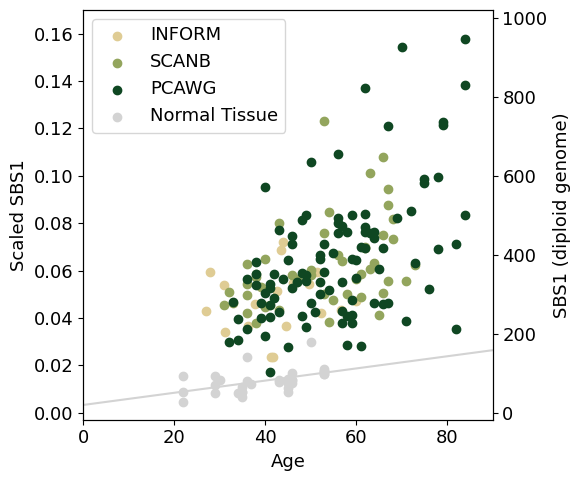

In [13]:
x = NormalTissueExposures['age']
y = NormalTissueExposures['scaled_SBS1']
slope, intercept, *_ = linregress(x, y)
x_fit = np.linspace(0, 90, 100)
y_fit = slope * x_fit + intercept

SBS1_acceleration_df = pd.concat([PCAWG_Metadata, SCANB_Metadata, INFORM_Metadata])
colors = {'INFORM': '#DFCC94', 'SCANB': '#93A55D', 'PCAWG': '#0F4722'}

fig, ax = plt.subplots(figsize=(6, 5))

# Main scatter plot
for cohort, color in colors.items():
    df = SBS1_acceleration_df[SBS1_acceleration_df['Cohort'] == cohort]
    ax.scatter(df['age'], df['scaled_SBS1'], label=cohort, color=color)

ax.scatter(x, y, color='lightgrey', label='Normal Tissue')
ax.plot(x_fit, y_fit, '-', color='lightgrey')

ax.set_xlabel('Age')
ax.set_ylabel('Scaled SBS1')
ax.legend(loc='upper left')
ax.set_xlim(0, 90)
ax.set_ylim(-0.003, 0.17)

# Add second y-axis
ax2 = ax.twinx()
ax2.set_ylim(ax.get_ylim()[0] * 2 * 3000, ax.get_ylim()[1] * 2 * 3000)
ax2.set_ylabel('SBS1 (diploid genome)')

plt.tight_layout()
plt.savefig("/Users/michail/HMS Dropbox/Michail Andreopoulos/HRDTimer/data/output/output_plots/SBS1_Acceleration_Bulk.pdf", format='pdf', bbox_inches='tight')
plt.show()


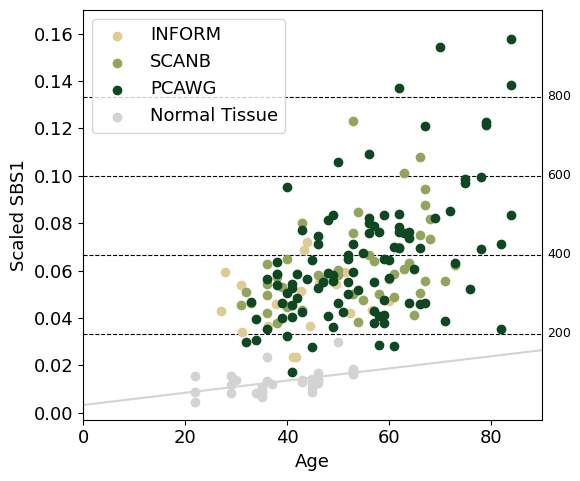

In [17]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import linregress

x = NormalTissueExposures['age']
y = NormalTissueExposures['scaled_SBS1']
slope, intercept, *_ = linregress(x, y)
x_fit = np.linspace(0, 90, 100)
y_fit = slope * x_fit + intercept

SBS1_acceleration_df = pd.concat([PCAWG_Metadata, SCANB_Metadata, INFORM_Metadata])
colors = {'INFORM': '#DFCC94', 'SCANB': '#93A55D', 'PCAWG': '#0F4722'}

fig, ax = plt.subplots(figsize=(6, 5))

# Main scatter plot
for cohort, color in colors.items():
    df = SBS1_acceleration_df[SBS1_acceleration_df['Cohort'] == cohort]
    ax.scatter(df['age'], df['scaled_SBS1'], label=cohort, color=color)

# Add normal tissue scatter and fit
ax.scatter(x, y, color='lightgrey', label='Normal Tissue')
ax.plot(x_fit, y_fit, '-', color='lightgrey')

ax.set_xlabel('Age')
ax.set_ylabel('Scaled SBS1')
ax.set_xlim(0, 90)
ax.set_ylim(-0.003, 0.17)

# Add dotted horizontal lines for selected SBS1 (diploid genome) values
diploid_values = [200,400,600, 800]
for val in diploid_values:
    scaled_val = val / 6000  # convert to scaled SBS1 units
    ax.axhline(y=scaled_val, linestyle='--', color='k', linewidth=0.8, zorder=0)
    ax.text(91, scaled_val, f'{val}', va='center', ha='left', fontsize=9)

ax.legend(loc='upper left')

plt.tight_layout()
plt.savefig("/Users/michail/HMS Dropbox/Michail Andreopoulos/HRDTimer/data/output/output_plots/SBS1_Acceleration_Bulk.pdf", format='pdf', bbox_inches='tight')
plt.show()


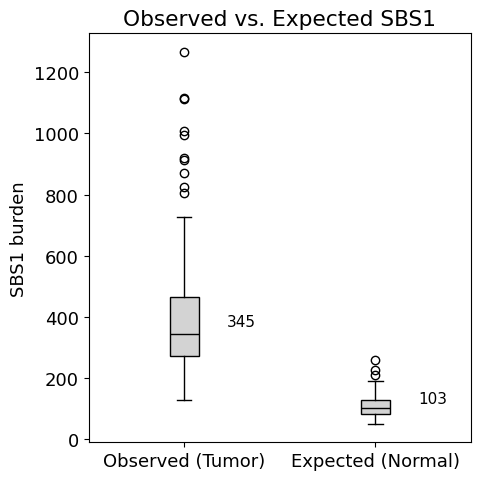

In [18]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.stats import linregress

# Linear fit for normal tissue
x = NormalTissueExposures['age']
y = NormalTissueExposures['scaled_SBS1']
slope, intercept, *_ = linregress(x, y)

# Combine tumor data
SBS1_acceleration_df = pd.concat([PCAWG_Metadata, SCANB_Metadata, INFORM_Metadata])

# Calculate SBS1 burden per sample
SBS1_acceleration_df['SBS1_patient'] = SBS1_acceleration_df['scaled_SBS1'] * 3000 * SBS1_acceleration_df['G']

# Calculate expected SBS1 at that age from normal tissue line
SBS1_acceleration_df['SBS1_normal'] = (slope * SBS1_acceleration_df['age'] + intercept) * SBS1_acceleration_df['G'] * 3000

# Drop NaNs for plotting
obs = SBS1_acceleration_df['SBS1_patient'].dropna()
exp = SBS1_acceleration_df['SBS1_normal'].dropna()

# Calculate medians
median_obs = np.median(obs)
median_exp = np.median(exp)

# Create boxplot
plt.figure(figsize=(5, 5))
box = plt.boxplot(
    [obs, exp],
    labels=['Observed (Tumor)', 'Expected (Normal)'],
    patch_artist=True,
    boxprops=dict(facecolor='lightgrey'),
    medianprops=dict(color='black')
)

# Annotate medians on top of the boxes
plt.text(1.3, median_obs + 0.05 * median_obs, f"{median_obs:.0f}", ha='center', va='bottom', fontsize=11)
plt.text(2.3, median_exp + 0.05 * median_exp, f"{median_exp:.0f}", ha='center', va='bottom', fontsize=11)

plt.ylabel('SBS1 burden')
plt.title('Observed vs. Expected SBS1')
plt.tight_layout()

# Save the plot
# plt.savefig("/Users/michail/HMS Dropbox/Michail Andreopoulos/HRDTimer/data/output/output_plots/SBS1_Observed_vs_Expected_Boxplot.pdf", format='pdf', bbox_inches='tight')
plt.show()


# Sanger Data - Pre process and Analyze

In [44]:
import pandas as pd, os

def splitMutsPrimMet(input_folder, output_folder):
    os.makedirs(output_folder, exist_ok=True)
    for f in os.listdir(input_folder):
        if f.endswith('.txt'):
            df = pd.read_csv(os.path.join(input_folder, f), sep='\t')
            prefix = f.split('_dirichlet')[0]
            cols = ['Chrom', 'Pos', 'ID', 'Ref', 'Alt', 'nMin1.a', 'nMin2.a', 'nMin1.c', 'nMin2.c', 'nMaj1.a', 'nMaj2.a', 'nMaj1.c', 'nMaj2.c']
            for c in cols: df[c] = df.get(c, '.')
            df['INFO'] = df.apply(lambda r: ';'.join(f"{k}={r[k]}" for k in cols[5:]), axis=1)
            df = df[['Chrom', 'Pos', 'ID', 'Ref', 'Alt', 'INFO', 'timing']]
            for labels, suffix in [(['SHARED', 'PRIM_ONLY'], 'shared_prim'), (['SHARED', 'MET_ONLY'], 'shared_met')]:
                sub = df[df['timing'].isin(labels)]
                with open(os.path.join(output_folder, f"{prefix}_{suffix}.vcf"), 'w') as out:
                    out.write('##fileformat=VCFv4.2\n#CHROM\tPOS\tID\tREF\tALT\tINFO\n')
                    sub.to_csv(out, sep='\t', header=False, index=False)

In [45]:
input_folder = 'SangerData'
output_folder = 'AA_SangerData_PostProcess/vcfs'
splitMutsPrimMet(input_folder='SangerData',
                 output_folder=output_folder)

In [46]:
Analyze.cosmic_fit("AA_SangerData_PostProcess/vcfs",
                   "AA_SangerData_PostProcess/vcfs" + '/SigProfiler/', 
                   input_type="vcf", context_type="96",
                   collapse_to_SBS96=False, cosmic_version=3.2, exome=False,
                   genome_build="GRCh37",
                   exclude_signature_subgroups=None, export_probabilities=False,
                   export_probabilities_per_mutation=False, make_plots=False,
                   sample_reconstruction_plots=False, verbose=False)

Starting matrix generation for SNVs and DINUCs...Completed! Elapsed time: 4.12 seconds.
Matrices generated for 34 samples with 0 errors. Total of 221439 SNVs, 896 DINUCs, and 0 INDELs were successfully analyzed.
Assigning COSMIC sigs or Signature Database ...... 
|████████████████████████████████████████| 34/34 [100%] in 16.0s (2.13/s) 


 
Your Job Is Successfully Completed! Thank You For Using SigProfilerAssignment.
 


In [37]:
mutation_matrix = pd.read_csv('AA_SangerData_PostProcess/vcfs/output/SBS/Input_vcffiles.SBS96.all', delimiter='\t', index_col=0)
catalog = musical.load_catalog('COSMIC_v3p2_SBS_WGS')
catalog.restrict_catalog(tumor_type='Breast.AdenoCA', is_MMRD=False, is_PPD=False)
W = catalog.W
W = W.reindex(mutation_matrix.index)
mutation_matrix = mutation_matrix.loc[:, (mutation_matrix != 0).any(axis=0)]
H_Mets, model_Mets = musical.refit.refit(mutation_matrix, W, method='likelihood_bidirectional', thresh=0.001)

In [38]:
Mets_Metadata = pd.read_csv("SangerPaperData.txt", delimiter='\t')
Mets_Metadata['Relapse age'] = Mets_Metadata['Primary_age'] + Mets_Metadata['Relapse_time'] 
Mets_Metadata['Norm_Prim_CpG'] = Mets_Metadata['Primary_CpG_muts'].div(Mets_Metadata['Primary_ploidy'] * 3000)
Mets_Metadata['Norm_Rel_CpG'] = Mets_Metadata['Relapse_CpG_muts'].div(Mets_Metadata['Relapse_ploidy'] * 3000)

In [39]:
def addSBS1ToMetadata(df1, df2):
    df = pd.merge(df1, df2, left_on='ID', right_index=True, how='left')
    for i, r in df.iterrows():
        for t in ['prim', 'met']:
            for s in ['SBS1']:
                col = f"{r['ID']}_shared_{t}"
                if col in df2.columns:
                    df.at[i, f"{s}_{t}"] = df2.at[s, col]
    df.drop(columns=[c for c in df2.columns if '_prim' in c or '_met' in c], inplace=True)
    return df

Mets_Metadata = addSBS1ToMetadata(Mets_Metadata, H_Mets)

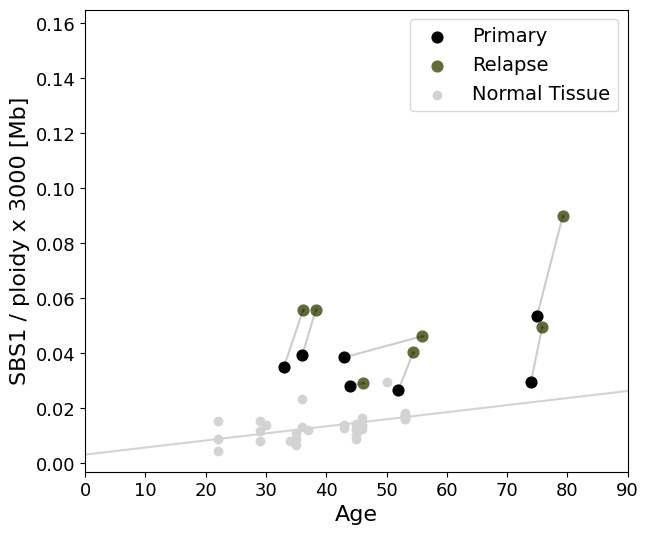

In [ ]:
Mets_Metadata['scaled_Prim_SBS1'] = Mets_Metadata['SBS1_prim'] / (Mets_Metadata['Primary_ploidy'] * 3000)
Mets_Metadata['scaled_Rel_SBS1'] = Mets_Metadata['SBS1_met'] / (Mets_Metadata['Relapse_ploidy'] * 3000)
Mets_Metadata = Mets_Metadata.drop(columns=['Acc_CpG', 'Acc_max', 'Acc_min', 'Primary_effGenome'])
Mets_Metadata.to_csv("AAA_Apr25_plots/data/Metastasis_SBS1_Age_plot.csv")

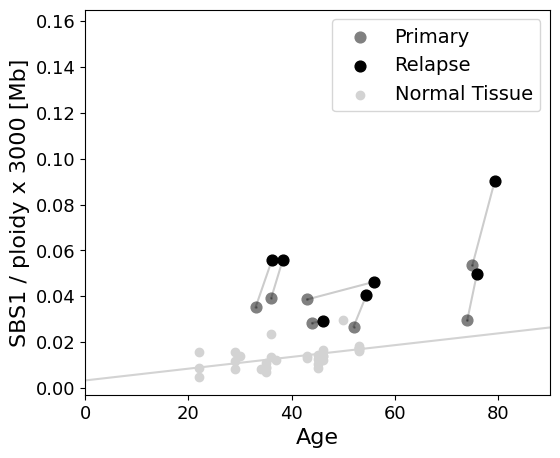

In [31]:
Mets_Metadata = pd.read_csv("/Volumes/extSSD/park_lab/HRDTimer_Analysis/AAA_Apr25_plots/data/Metastasis_SBS1_Age_plot.csv")

mpl.rcParams['pdf.fonttype'] = 42

NormalTissueExposures = pd.read_csv("/Volumes/extSSD/park_lab/HRDTimer_Analysis/AAA_Apr25_plots/data/NormalTissue_SBS1_Age_plot.csv")
x = NormalTissueExposures['age']
y = NormalTissueExposures['scaled_SBS1']
slope, intercept, *_ = linregress(x, y)
x_fit = np.linspace(0, 90, 100)
y_fit = slope * x_fit + intercept

plt.figure(figsize=(6, 5))
for _, r in Mets_Metadata.iterrows():
    plt.plot([r['Primary_age'], r['Relapse age']], [r['scaled_Prim_SBS1'], r['scaled_Rel_SBS1']], c="k", alpha=0.2, marker='o', markersize=1)
plt.scatter(Mets_Metadata['Primary_age'], Mets_Metadata['scaled_Prim_SBS1'], s=60, color='grey', label='Primary')
plt.scatter(Mets_Metadata['Relapse age'], Mets_Metadata['scaled_Rel_SBS1'], s=60, color='k', label='Relapse')
plt.scatter(x, y, color='lightgrey', label='Normal Tissue')
plt.plot(x_fit, y_fit, '-', color='lightgrey')
plt.xlabel('Age', fontsize=16)
plt.ylabel('SBS1 / ploidy x 3000 [Mb]', fontsize=16)
plt.xlim(0, 90)
plt.ylim(-0.003, 0.165)
plt.legend(fontsize=14)
plt.savefig("/Users/michail/HMS Dropbox/Michail Andreopoulos/HRDTimer/data/output/output_plots/SBS1_Acceleration_Mets.pdf", format='pdf', bbox_inches='tight')
plt.show()
